# CPU time analysis

## Setup

In [5]:
import re
import datetime
from math import log
import csv
import pprint
import math
import random
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pandas as pd
from elasticsearch import Elasticsearch, helpers

from __future__ import division

%matplotlib inline

pp = pprint.PrettyPrinter()

## Open connection to ES

In [3]:
es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)

## List all jobs\_archive\_* indices

In [4]:
indices = es.cat.indices(index="jobs_archive_*", h="index", request_timeout=600).split('\n')
indices = sorted(indices)
indices = [x for x in indices if x != '']

## Function to list all jobs\_archive\_* indices in the last N days

In [12]:
def time_filter(indices, days=0, until=0):
    if days == 0:
        return ["jobs_archive_*"]
    today = datetime.date.today()
    filtered = []
    datefmt = '%Y-%m-%d'
    for i in indices:
        day = re.sub(r'jobs_archive_', '', i).rstrip()
        day = datetime.datetime.strptime(day, datefmt).date()
        diff = today - day
        if until <= diff.days < days + until:
            filtered.append(i.rstrip())
    return filtered

## Group by (processingtype, transformation) and plot distribution of average CPU time/event by jeditaskid

In [52]:
# Change second argument to use a different time range for ES queries
ind = time_filter(indices, 0, 0)
ind = ','.join(ind)
ind

'jobs_archive_*'

I select only jobs with at least one event, successful, with a core count of at least one and that ran for at least 60 seconds.

I exclude test and analysis jobs.

I aggregate jobs by _processingtype_, _transformation_, _atlasrelease_, _computingsite_ and _jeditaskdid_.
In practice, all jobs in a task have the same value of all these variables save for the site, so each bucket corresponds to a combination of (_jeditaskid_, _computingsite_).

I record these quantities:

* Average of CPU time per event
* Average of wall-clock time per event
* Total CPU time
* Total wall-clock time (that is, multiplied by the number of cores)
* Average of core count
* Total number of events
* Average of CPU time divided by wall-clock time

Already at this level there's a theoretical flaw: averages of time and efficiency are done from the values of each individual job, disregarding the number of events in the job. The averages are correct only if all jobs in a task process the same number of jobs. **This is not strictly the case, but usually all jobs in a task have at least very similar numbers of events**.

In [34]:
s = {
    "size": 0,
    "query": {
        "filtered": {
            "filter": {
                "bool": {
                    "must": [
                        {
                            "range": {
                                "nevents": {"gte": 1}
                            }
                        },
                        {
                            "range": {
                                "corecount": {"gte": 1}
                            }
                        },
                        {
                            "range": {
                                "wall_time": {"gt": 60, "lt": 2590000}
                            }
                        },
                        { 
                            "match": {
                                "prodsourcelabel":"managed"
                            }
                        },
                        {
                            "match": {
                                "jobstatus": "finished"
                            }
                        }
                    ],
                    "must_not": [
                        {
                            "query": {
                                "wildcard": {
                                    "processingtype": "panda*"
                                }
                            }
                        },
                        {
                            "query": {
                                "wildcard": {
                                    "processingtype": "pmerge*"
                                }
                            }
                        },
                        {
                            "query": {
                                "wildcard": {
                                    "processingtype": "merge*"
                                }
                            }
                        },
                        {
                            "query": {
                                "wildcard": {
                                    "processingtype": "hammercloud*"
                                }
                            }
                        },
                        {
                            "query": {
                                "wildcard": {
                                    "processingtype": "ganga*"
                                }
                            }
                        },
                        {
                            "query": {
                                "match": {
                                    "computingsite": "BOINC"
                                }
                            }
                        }
                    ]
                }
            }
        }
    },
    "aggs": {
        "ptypes": {
            "terms": {
                "field": "processingtype",
                "size": 1000
            },
            "aggs": {
                "transf": {
                    "terms": {
                        "field": "transformation",
                        "size": 1000
                    },
                    "aggs": {
                        "atlrel": {
                            "terms": {
                                "field": "atlasrelease",
                                "size": 1000
                            },
                            "aggs": {
                                "site": {
                                    "terms": {
                                        "field": "computingsite",
                                        "size": 1000
                                    },
                                    "aggs": {
                                        "cputype": {
                                            "terms": {
                                                "field": "cpuconsumptionunit",
                                                "size": 1000
                                            },
                                            "aggs": {
                                                "jtask": {
                                                    "terms": {
                                                        "field": "jeditaskid",
                                                        "size": 100000
                                                    },
                                                    "aggs": {
                                                        "1": {
                                                            "extended_stats": {
                                                                "script": "(doc['nevents'].value) ? doc['cpuconsumptiontime'].value/doc['nevents'].value : 0",
                                                                "lang": "expression"
                                                            }
                                                        },
                                                        "2": {
                                                            "extended_stats": {
                                                                "script": "(doc['nevents'].value) ? doc['wall_time'].value * doc['corecount'].value / doc['nevents'].value : 0",
                                                                "lang": "expression"
                                                            }
                                                        },
                                                        "3": {
                                                            "sum": {
                                                                "field": "cpuconsumptiontime"
                                                            }
                                                        },
                                                        "4": {
                                                            "sum": {
                                                                "script": "doc['wall_time'].value * doc['corecount'].value",
                                                                "lang": "expression"
                                                            }
                                                        },
                                                        "6": {
                                                            "avg": {
                                                                "field": "corecount"
                                                            }
                                                        },
                                                        "7": {
                                                            "sum": {
                                                                "field": "nevents"
                                                            }
                                                        },
                                                        "8": {
                                                            "avg": {
                                                                "script": "doc['cpuconsumptiontime'].value/doc['wall_time'].value/doc['corecount'].value",
                                                                "lang": "expression"
                                                            }
                                                        }
                                                    }
                                                }
                                            }
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            }
        }
    }
}
res = es.search(index=ind, body=s, request_timeout=12000)

## Write data to a CSV file

In [35]:
output_file = 'task_cpu_90d_7.csv'

In [36]:
with open(output_file, 'w') as f:
    writer = csv.writer(f, lineterminator='\n')
    buckets1 = res['aggregations']['ptypes']['buckets']
    for b1 in buckets1:
        ptype = b1['key']
        buckets2 = b1['transf']['buckets']
        for b2 in buckets2:
            transf = b2['key']
            buckets3 = b2['atlrel']['buckets']
            for b3 in buckets3:
                atlrel = b3['key']
                buckets4 = b3['site']['buckets']
                for b4 in buckets4:
                    site = b4['key']
                    buckets5 = b4['cputype']['buckets']
                    for b5 in buckets5:
                        cputype = b5['key']
                        buckets6 = b5['jtask']['buckets']
                        for b6 in buckets6:
                            jtask = b6['key']
                            writer.writerow([
                                jtask,
                                ptype,
                                transf,
                                atlrel,
                                site,
                                cputype,
                                b6['1']['count'],
                                b6['1']['avg'],
                                b6['1']['std_deviation'],
                                b6['2']['avg'],
                                b6['2']['std_deviation'],
                                b6['3']['value'],
                                b6['4']['value'],
                                b6['6']['value'],
                                b6['7']['value'],
                                b6['8']['value']
                                ])

## Import to a DataFrame

In [37]:
input_file = 'task_cpu.csv'

In [38]:
df = pd.read_csv(input_file, dtype={'cpu_n': 'float'}, names=['jeditaskid', 'processingtype', 'transformation', 'atlrel', 'site',
                                                               'cputype', 'njobs', 'cpuevt_avg', 'cpuevt_rms', 'wallevt_avg',
                                                               'wallevt_rms', 'cpu', 'wc', 'cores', 'jevts', 'eff'])

In [39]:
df[:10]

,jeditaskid,processingtype,transformation,atlrel,site,cputype,njobs,cpuevt_avg,cpuevt_rms,wallevt_avg,wallevt_rms,cpu,wc,cores,jevts,eff
0,4610250,simul,Sim_tf.py,Atlas-17.7.4,CERN-P1_MCORE_HI,s+Westmere E56xx/L56xx/X56xx (Nehalem-C) 4096 KB,6589,261.843331,12.955051,302.893113,14.977942,172528571,199576272,8,658900,0.864689
1,4610298,simul,Sim_tf.py,Atlas-17.7.4,CERN-P1_MCORE_HI,s+Westmere E56xx/L56xx/X56xx (Nehalem-C) 4096 KB,35,646.672286,20.988889,720.066286,31.949334,2263353,2520232,8,3500,0.898879
2,4610278,simul,Sim_tf.py,Atlas-17.7.4,CERN-P1_MCORE_HI,s+Westmere E56xx/L56xx/X56xx (Nehalem-C) 4096 KB,1,543.950000,0.000000,584.720000,0.000000,54395,58472,8,100,0.930274
3,4610250,simul,Sim_tf.py,Atlas-17.7.4,CERN-P1_MCORE_HI,s+Intel Core i7 9xx (Nehalem Class Core i7) 40...,2696,275.686736,13.540158,319.230059,15.540752,74325144,86064424,8,269600,0.863807
4,4610298,simul,Sim_tf.py,Atlas-17.7.4,CERN-P1_MCORE_HI,s+Intel Core i7 9xx (Nehalem Class Core i7) 40...,15,674.904667,17.829902,744.746667,28.446402,1012357,1117120,8,1500,0.906731
5,4610250,simul,Sim_tf.py,Atlas-17.7.4,IN2P3-CC_MCORE,s+Intel(R) Xeon(R) CPU X5650 @ 2.67...,8470,303.486125,47.606507,339.770087,51.237895,257052748,287785264,8,847000,0.892372
6,4610250,simul,Sim_tf.py,Atlas-17.7.4,SiGNET_MCORE,s+AMD Opteron(TM) Processor 6274 2048 KB,2372,417.893229,21.192265,492.759224,34.353389,99124274,116882488,8,237200,0.850179
7,4610270,simul,Sim_tf.py,Atlas-17.7.4,SiGNET_MCORE,s+AMD Opteron(TM) Processor 6274 2048 KB,116,768.409741,40.523725,898.923448,66.436233,8913553,10427512,8,11600,0.857531
8,4610306,simul,Sim_tf.py,Atlas-17.7.4,SiGNET_MCORE,s+AMD Opteron(TM) Processor 6274 2048 KB,98,1141.005918,46.429306,1259.722449,53.464812,11181858,12345280,8,9800,0.905969
9,4610282,simul,Sim_tf.py,Atlas-17.7.4,SiGNET_MCORE,s+AMD Opteron(TM) Processor 6274 2048 KB,1,879.640000,0.000000,990.400000,0.000000,87964,99040,8,100,0.888166


Grouping by _processingtype_ and _transformation_ to calculate e.g. the average CPU time per event for each combination has a problem: one cannot simply average the values in the same group because this does not take into account the fact that different values have different statistical weights. So, one must use as weights the number of events in each bucket.
Unfortunately pandas does not have a simple way to do it for more than one quantity.

## Averages of wall-clock times

In [40]:
# Define aggregation
grouped = df.groupby(['processingtype', 'transformation'], as_index=False)

# Define function to average a given quantity using the number of events es weight
def weighted_avg(group, a, w):
    return np.average(group[a], weights=group[w])

# Calculate Series with the correctly averaged CPU time per event
a = grouped.apply(weighted_avg,'wallevt_avg', 'wc')
a

processingtype  transformation        
digit           Reco_tf.py                  10.381486
                Reco_trf.py                  0.779837
eventIndex      POOLtoEI_tf.py              11.650590
evgen           EVNTMerge_tf.py              0.056866
                EvtGenFromEVNT_tf.py         0.066238
                Generate_tf.py            1291.839436
                Generate_trf.py            299.789543
pile            DigiMReco_trf.py           509.713473
                Digi_trf.py                  9.938971
                OverlayChain_tf.py         522.622126
                Reco_tf.py                 130.492612
recon           AODMerge_tf.py               0.687423
                DigiMReco_trf.py           304.863098
                RAWSkim_tf.py                0.463542
                Reco_tf.py                 103.814847
                Reco_trf.py                 36.745673
                Sim_tf.py                   53.001583
                TrigFTKTM64SM4Un_tf.py     

## Some statistics

The following is the list of (processingtype, transformation) combinations with some statistics.
Rows are sorted by decreasing wall-clock time.

In [41]:
grouped = df.groupby(['processingtype', 'transformation'], as_index=False)
a = grouped.agg({'jeditaskid': 'nunique', # ok!
                 'cpuevt_avg' : 'mean',   # wrong!
                 'wallevt_avg': 'mean',   # wrong!
                 'wc': 'sum',             # ok!
                 'cores': 'mean',         # wrong!
                 'njobs': 'sum',          # ok!
                 'jevts': 'sum'})         # ok!
a.sort_values('wc', ascending=False)

,processingtype,transformation,wc,cpuevt_avg,jevts,cores,wallevt_avg,njobs,jeditaskid
31,simul,Sim_tf.py,2.440201e+12,386.463344,7746945131,5.899537,445.092223,22199662,20727
10,pile,Reco_tf.py,1.142674e+12,66.360502,14952776818,7.459106,104.836618,12563766,36849
5,evgen,Generate_tf.py,8.787589e+11,725.595553,14884569712,1.029558,749.914487,24529888,18563
27,simul,AtlasG4_tf.py,2.757973e+11,653.060651,1712875461,1.229731,672.978625,10750912,33613
24,reprocessing,Reco_tf.py,2.239516e+11,79.272598,17913650669,5.578990,541.975010,8109902,5081
6,evgen,Generate_trf.py,9.485496e+10,55.110998,3263914267,1.000000,57.435216,2303157,34240
7,pile,DigiMReco_trf.py,9.415733e+10,124.359549,1359434428,1.000000,133.850109,3258672,18807
14,recon,Reco_tf.py,6.653016e+10,40.950622,2031946329,5.898553,72.296568,2746559,5091
28,simul,AtlasG4_trf.py,2.938679e+10,228.595803,272203371,1.000000,236.716657,888415,273
12,recon,DigiMReco_trf.py,2.760436e+10,96.270669,421357715,1.000000,102.419672,939830,15113


## Jobs per task

464.807100242


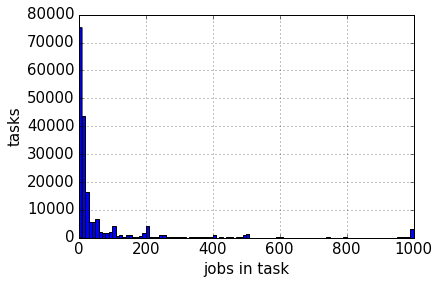

In [42]:
plt.rcParams.update({'font.size': 15})
grouped = df.groupby(['jeditaskid'], as_index=False)
a = grouped['njobs'].sum()
print np.mean(a['njobs'])
fig = a['njobs'].hist(bins=100, log=False, range=[0., 1000.])
plt.xlabel('jobs in task')
plt.ylabel('tasks')

## Events per task

15000.0


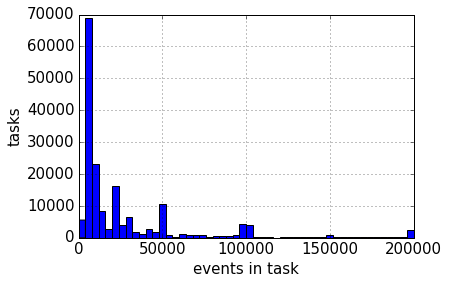

In [43]:
grouped = df.groupby(['jeditaskid'], as_index=False)
a = grouped['jevts'].sum()
print np.median(a['jevts'])
fig = a['jevts'].hist(bins=50, range=[0., 2e5], log=False)
plt.xlabel('events in task')
plt.ylabel('tasks')

## Distribution of efficiency

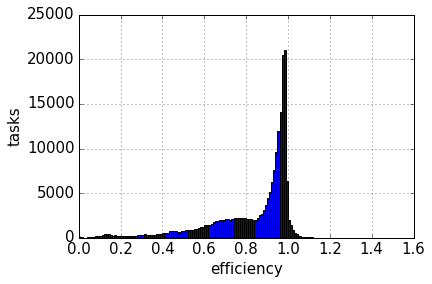

In [44]:
grouped = df.groupby(['jeditaskid'], as_index=False)
a = grouped['eff'].mean()
fig = a['eff'].hist(bins=150, log=False, range=(0, 1.5))   # NOT VERY CORRECT (arithmetic mean of efficiencies...)
plt.xlabel('efficiency')
plt.ylabel('tasks')

In the plot above, note the existence of efficiencies larger than 1! This has to be understood.

## Plot distribution of averages of CPU time per event for tasks grouped by processingtype and transformation

The following plots show the distribution of the average CPU time per event in tasks having the same processingtype and transformation. Therefore each histogram has a number of entries equal to the number of JEDI tasks for that combination.

The purpose of these plots is to show how much tasks of the same type can differ in terms of average CPU time per event.
Combinations consisting of merge jobs, of that account for less than 1.5% of the total wall-clock time, are ignored.

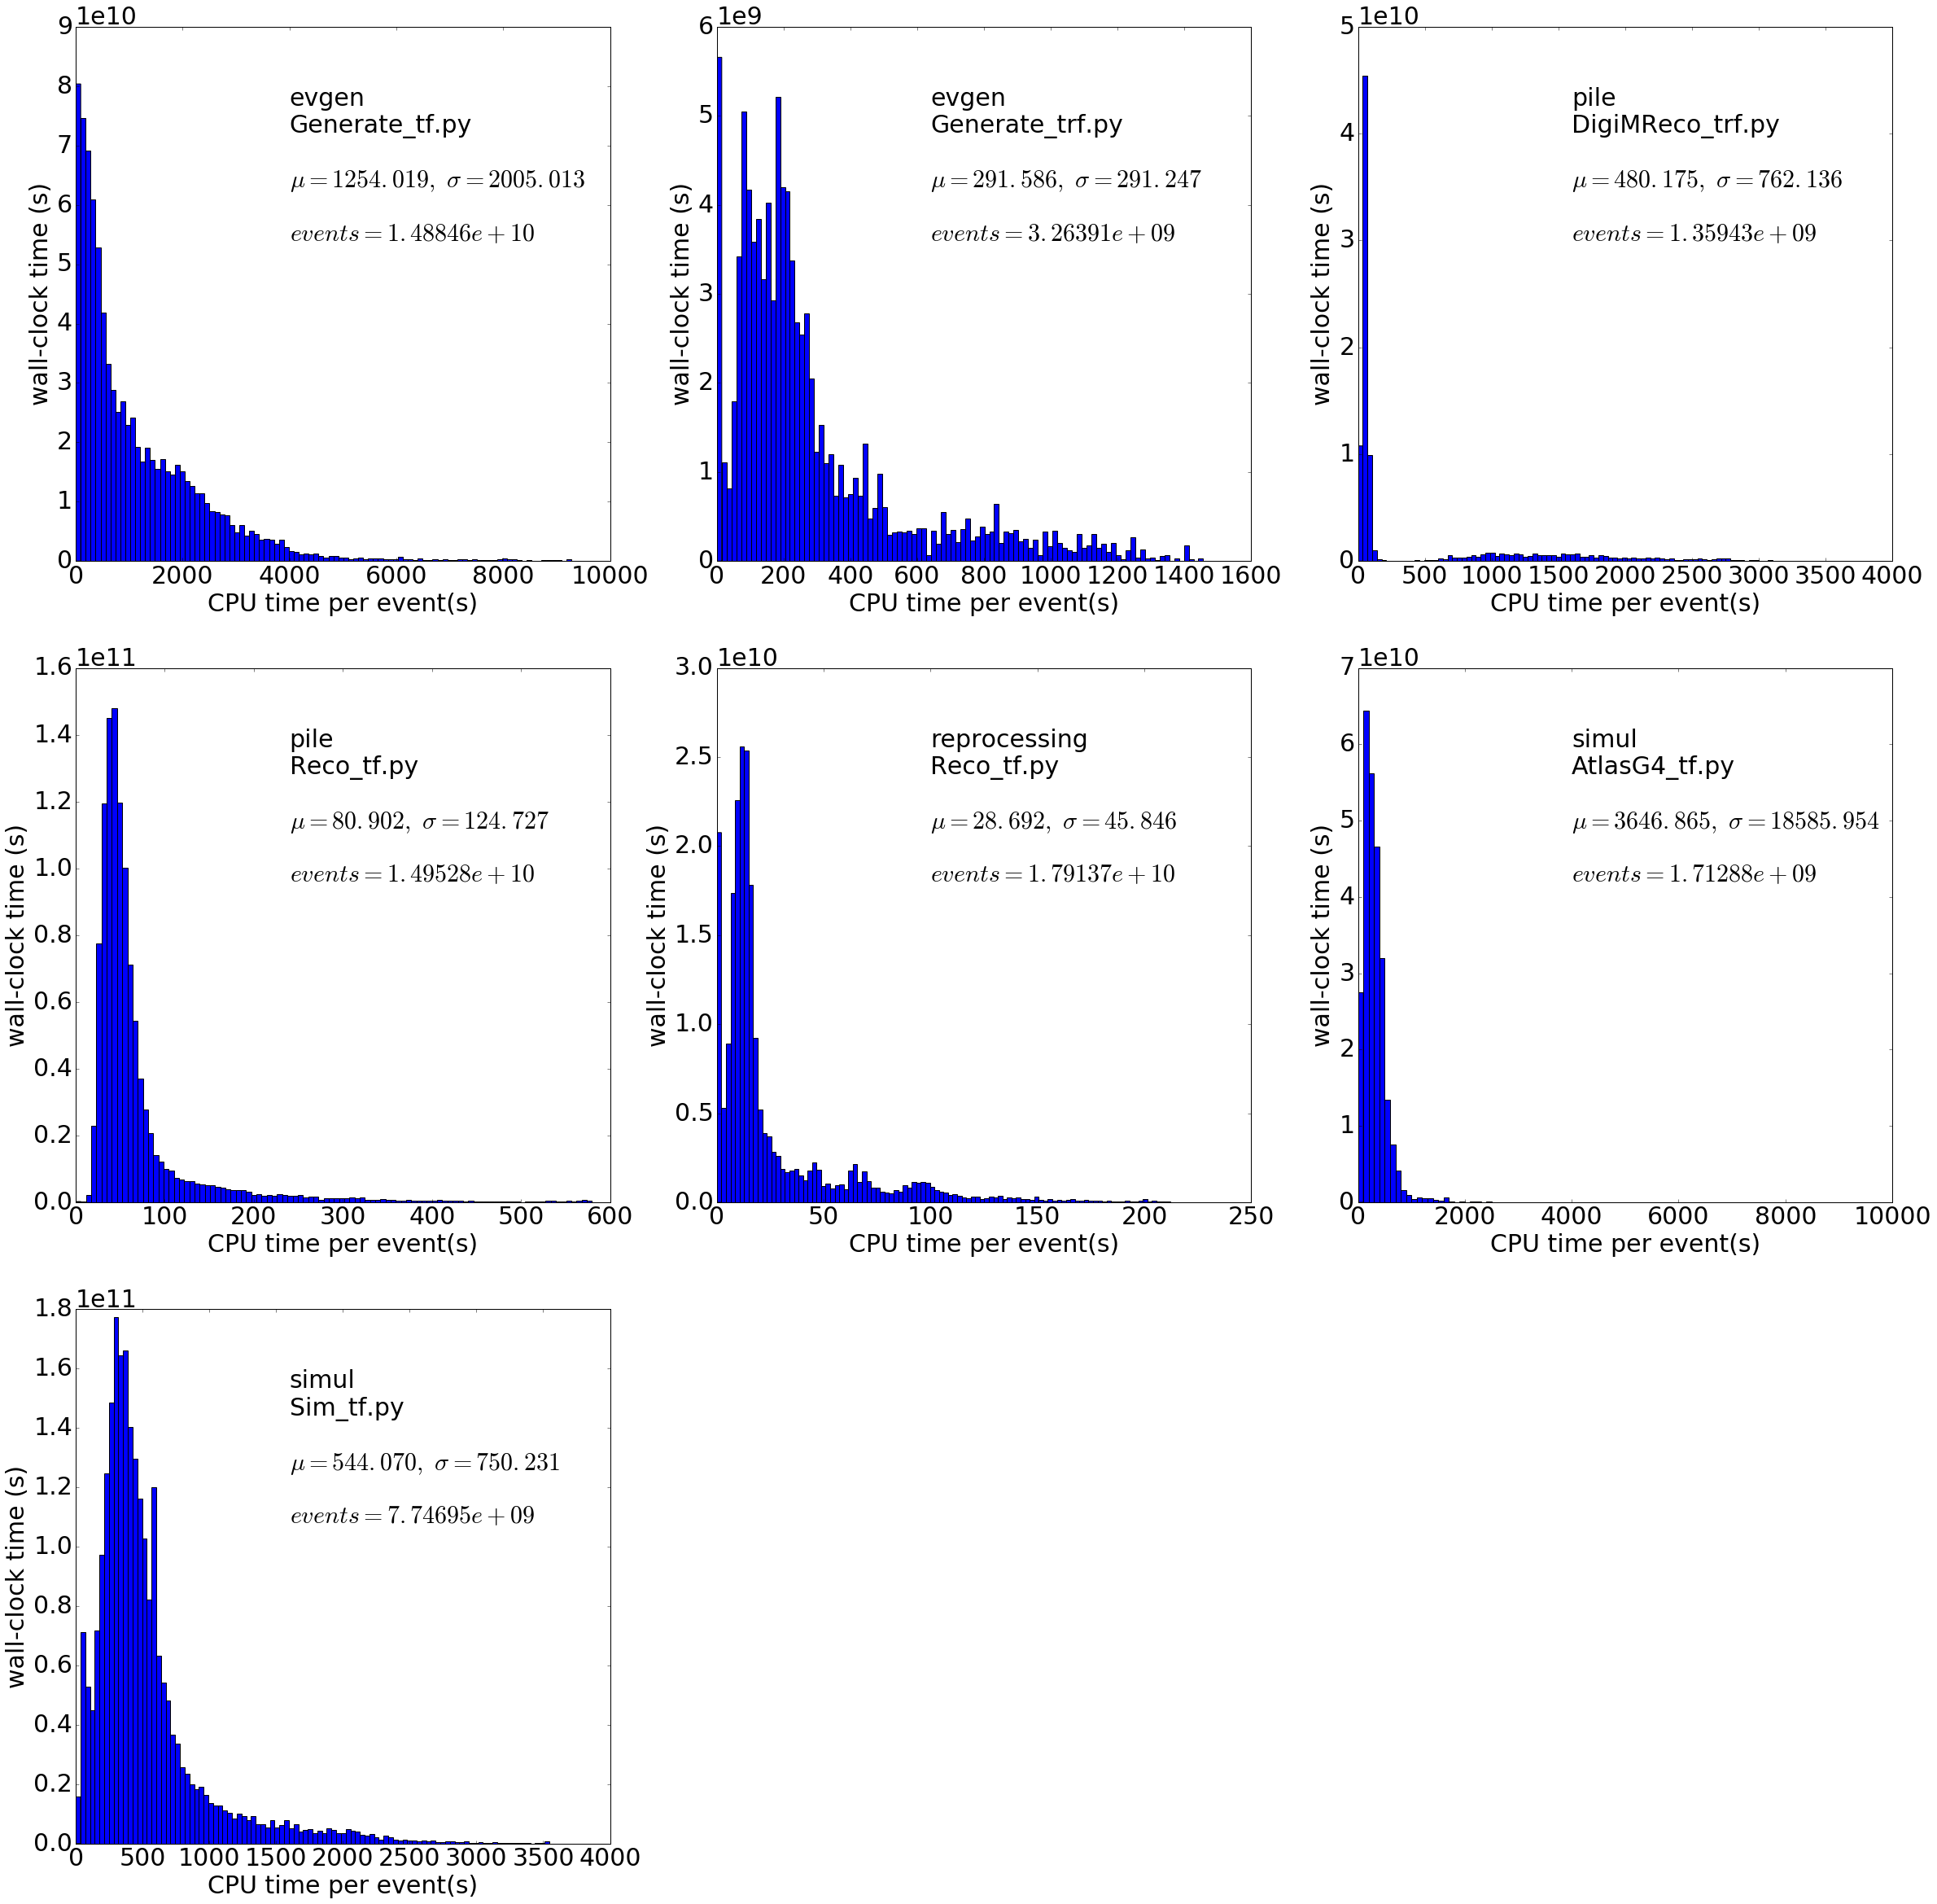

In [45]:
fig = plt.figure(figsize=(40,40))
plt.rcParams.update({'font.size': 30})
var = 'cpuevt_avg'
log_scale = False
wc_tot = df['wc'].sum()
i = 1

grouped = df.groupby(['processingtype', 'transformation'], as_index=False)

for (p, t), g in grouped:
    if re.search(r"merge", t, flags=re.IGNORECASE):
        continue
    if g['wc'].sum() < 0.015 * wc_tot:
        continue
    mean = np.average(g[var], weights=g['wc'])   # average time weighted with no. of events
    std = math.sqrt(np.average((g[var] - mean)**2, weights=g['wc']))
    range = [0., min(mean + std * 4., 10000.)]
    sp = plt.subplot(3, 3, i)
    plt.hist(g[var].tolist(), bins=100, range=range, weights=g['wc'].tolist(), log=log_scale)   # integral is total no. of events
    plt.xlabel('CPU time per event(s)')
    plt.ylabel('wall-clock time (s)')
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    stats = r'$\mu=%.3f,\ \sigma=%.3f$' % (mean, std)
    stats2 = r'$\mathit{events}=%g$' % g['jevts'].sum()
    if log_scale:
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.8, p+'\n'+t)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.7, stats)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.6, stats2)
    else:
        plt.text(t_x(.4), t_y(.8), p+'\n'+t)
        plt.text(t_x(.4), t_y(.7), stats)
        plt.text(t_x(.4), t_y(.6), stats2)
    i += 1

## Plot distribution of averages of wallclock time per event for tasks grouped by processingtype and transformation

The following plots show the distribution of the average wallclock time per event in tasks having the same processingtype and transformation. Therefore each histogram has a number of entries equal to the number of JEDI tasks for that combination.

The purpose of these plots is to show how much tasks of the same type can differ in terms of average wallclock time per event.

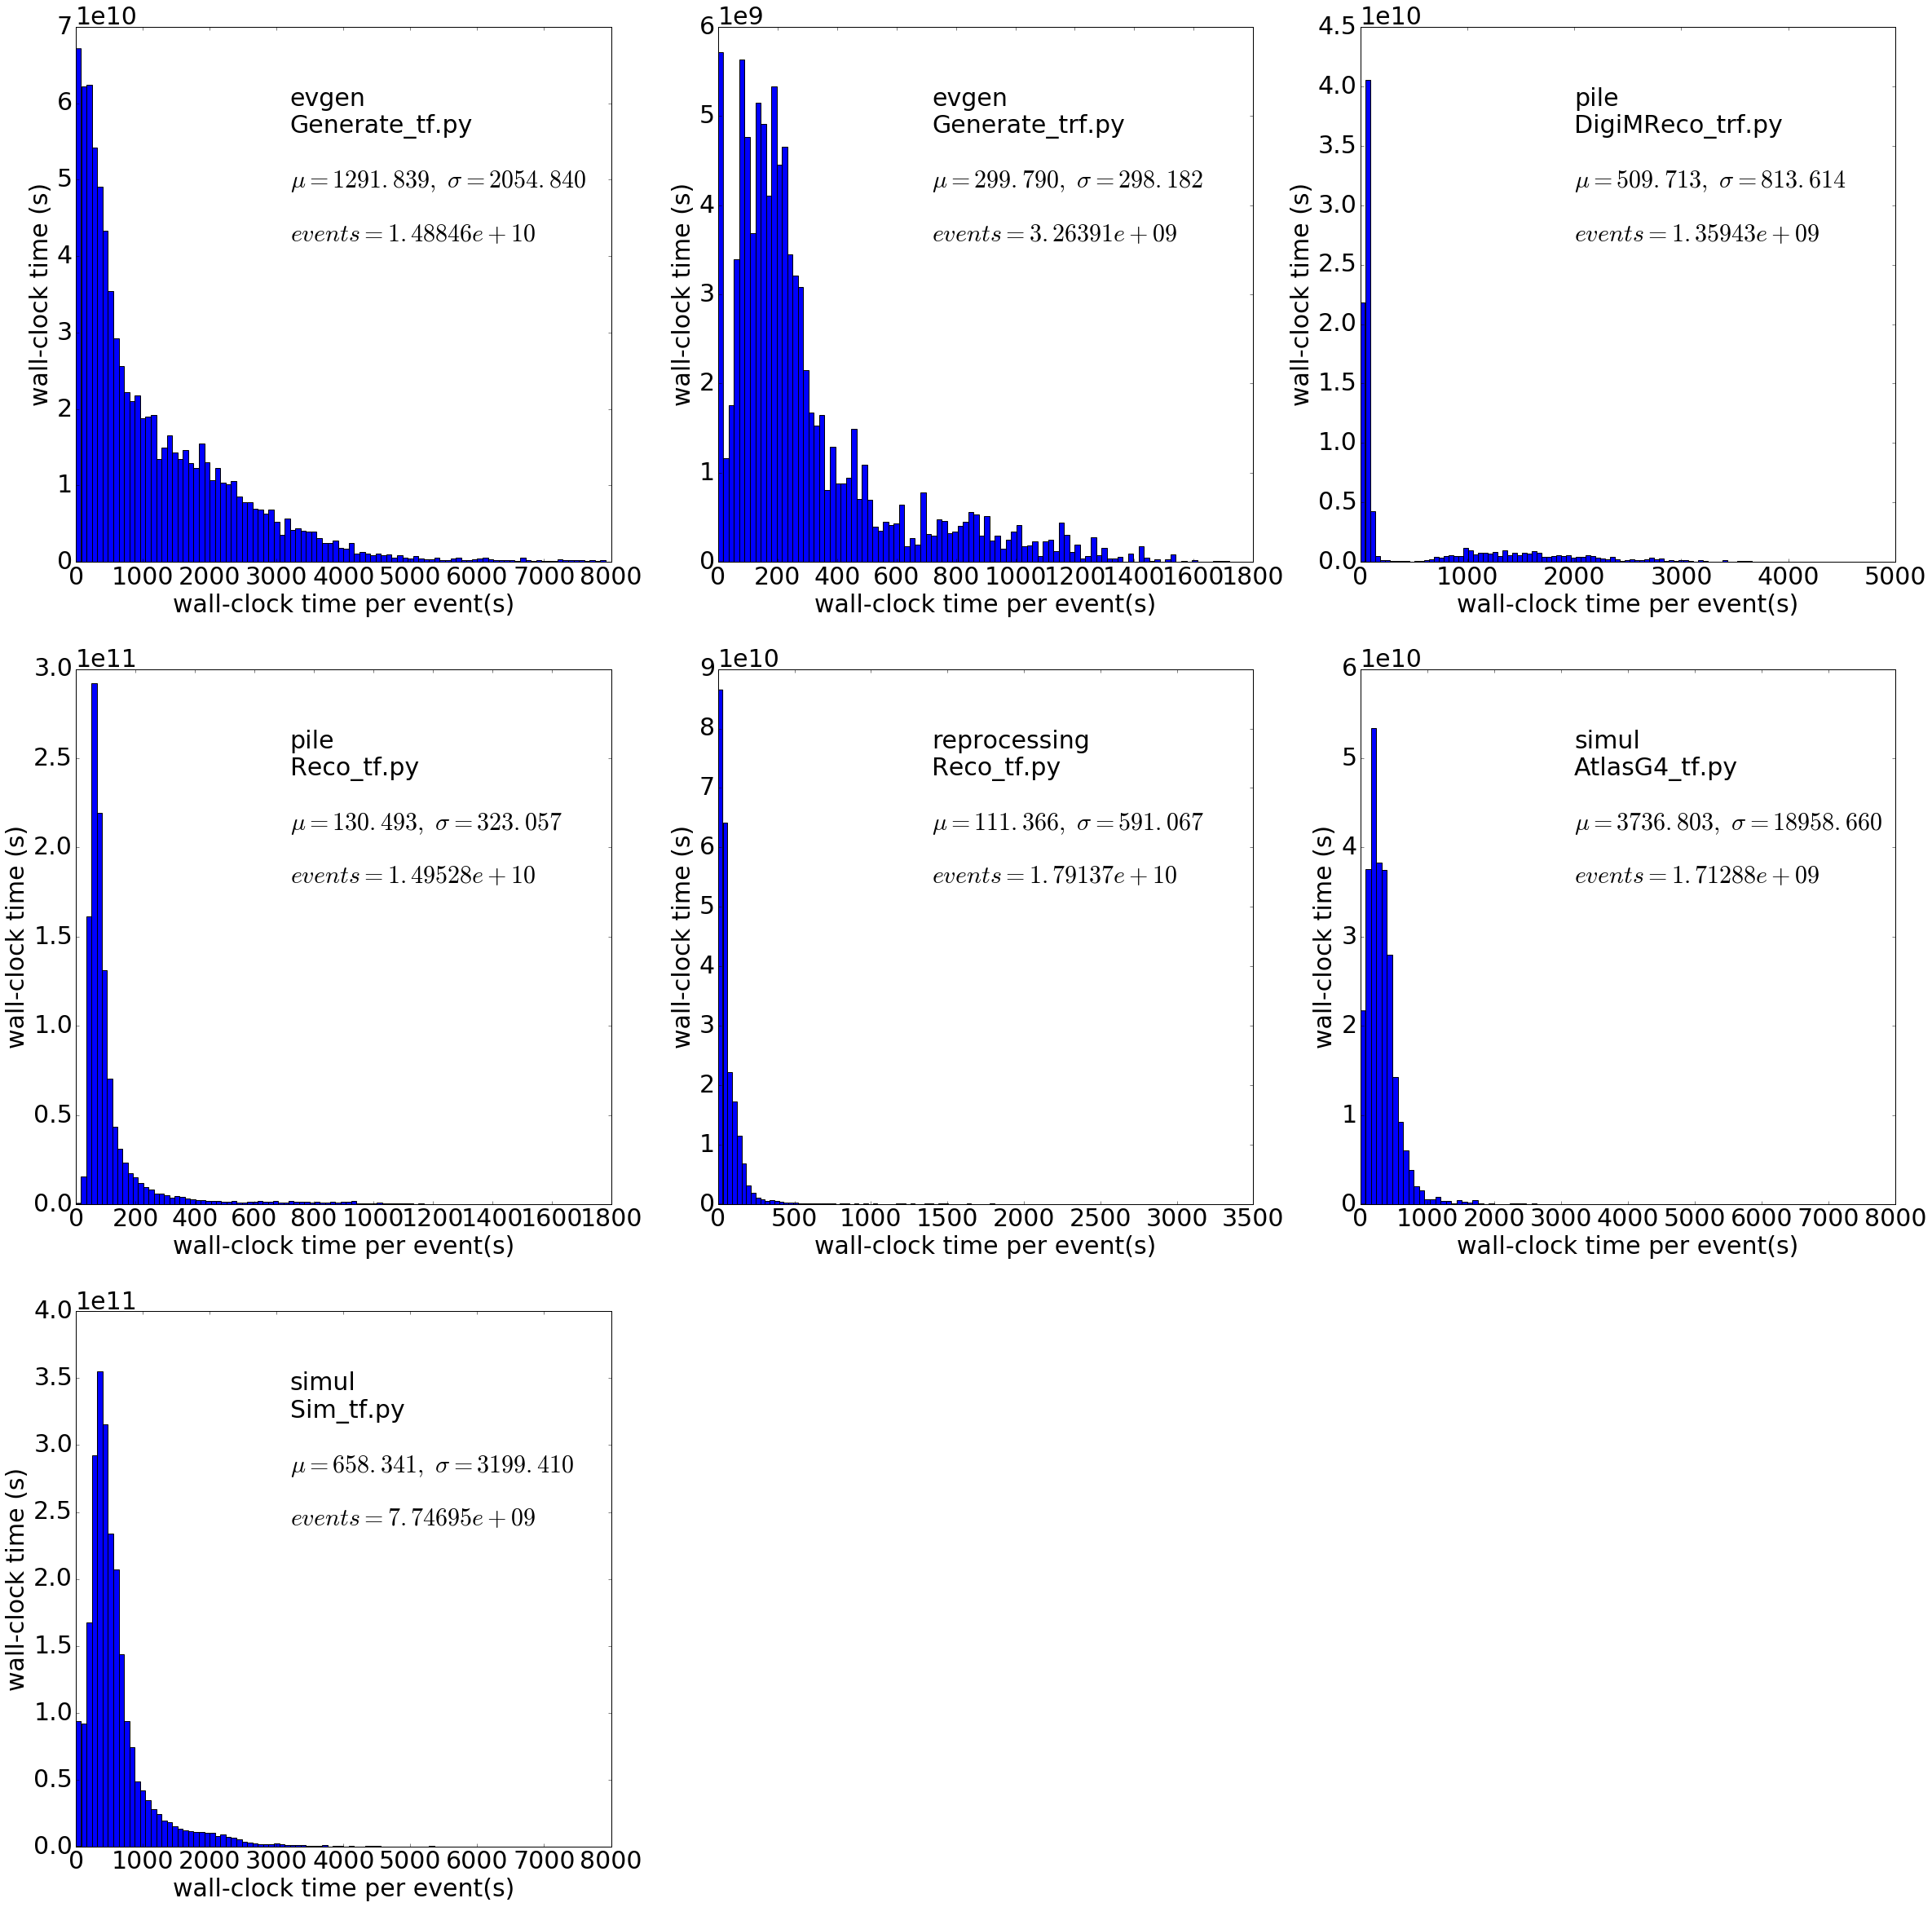

In [46]:
fig = plt.figure(figsize=(40,40))
plt.rcParams.update({'font.size': 30})
var = 'wallevt_avg'
log_scale = False
wc_tot = df['wc'].sum()
i = 1

grouped = df.groupby(['processingtype', 'transformation'], as_index=False)

for (p, t), g in grouped:
    if re.search(r"merge", t, flags=re.IGNORECASE):
        continue
    if g['wc'].sum() < 0.015 * wc_tot:
        continue
    mean = np.average(g[var], weights=g['wc'])   # average time weighted with no. of events
    std = math.sqrt(np.average((g[var] - mean)**2, weights=g['wc']))
    range = [0., min(mean + std * 5., 8000.)]
    sp = plt.subplot(3, 3, i)
    plt.hist(g[var].tolist(), bins=100, range=range, weights=g['wc'].tolist(), log=log_scale)   # integral is total no. of events
    plt.xlabel('wall-clock time per event(s)')
    plt.ylabel('wall-clock time (s)')
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    stats = r'$\mu=%.3f,\ \sigma=%.3f$' % (mean, std)
    stats2 = r'$\mathit{events}=%g$' % g['jevts'].sum()
    if log_scale:
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.8, p+'\n'+t)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.7, stats)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.6, stats2)
    else:
        plt.text(t_x(.4), t_y(.8), p+'\n'+t)
        plt.text(t_x(.4), t_y(.7), stats)
        plt.text(t_x(.4), t_y(.6), stats2)
    i += 1

## Plot distribution of averages of CPU efficiency per event for tasks grouped by processingtype and transformation

Total wall-clock: 5.31552e+12 s
Total wall-clock of evgen: 9.73614e+11 s
Total wall-clock of evgen with low efficiency: 2.76017e+10 s


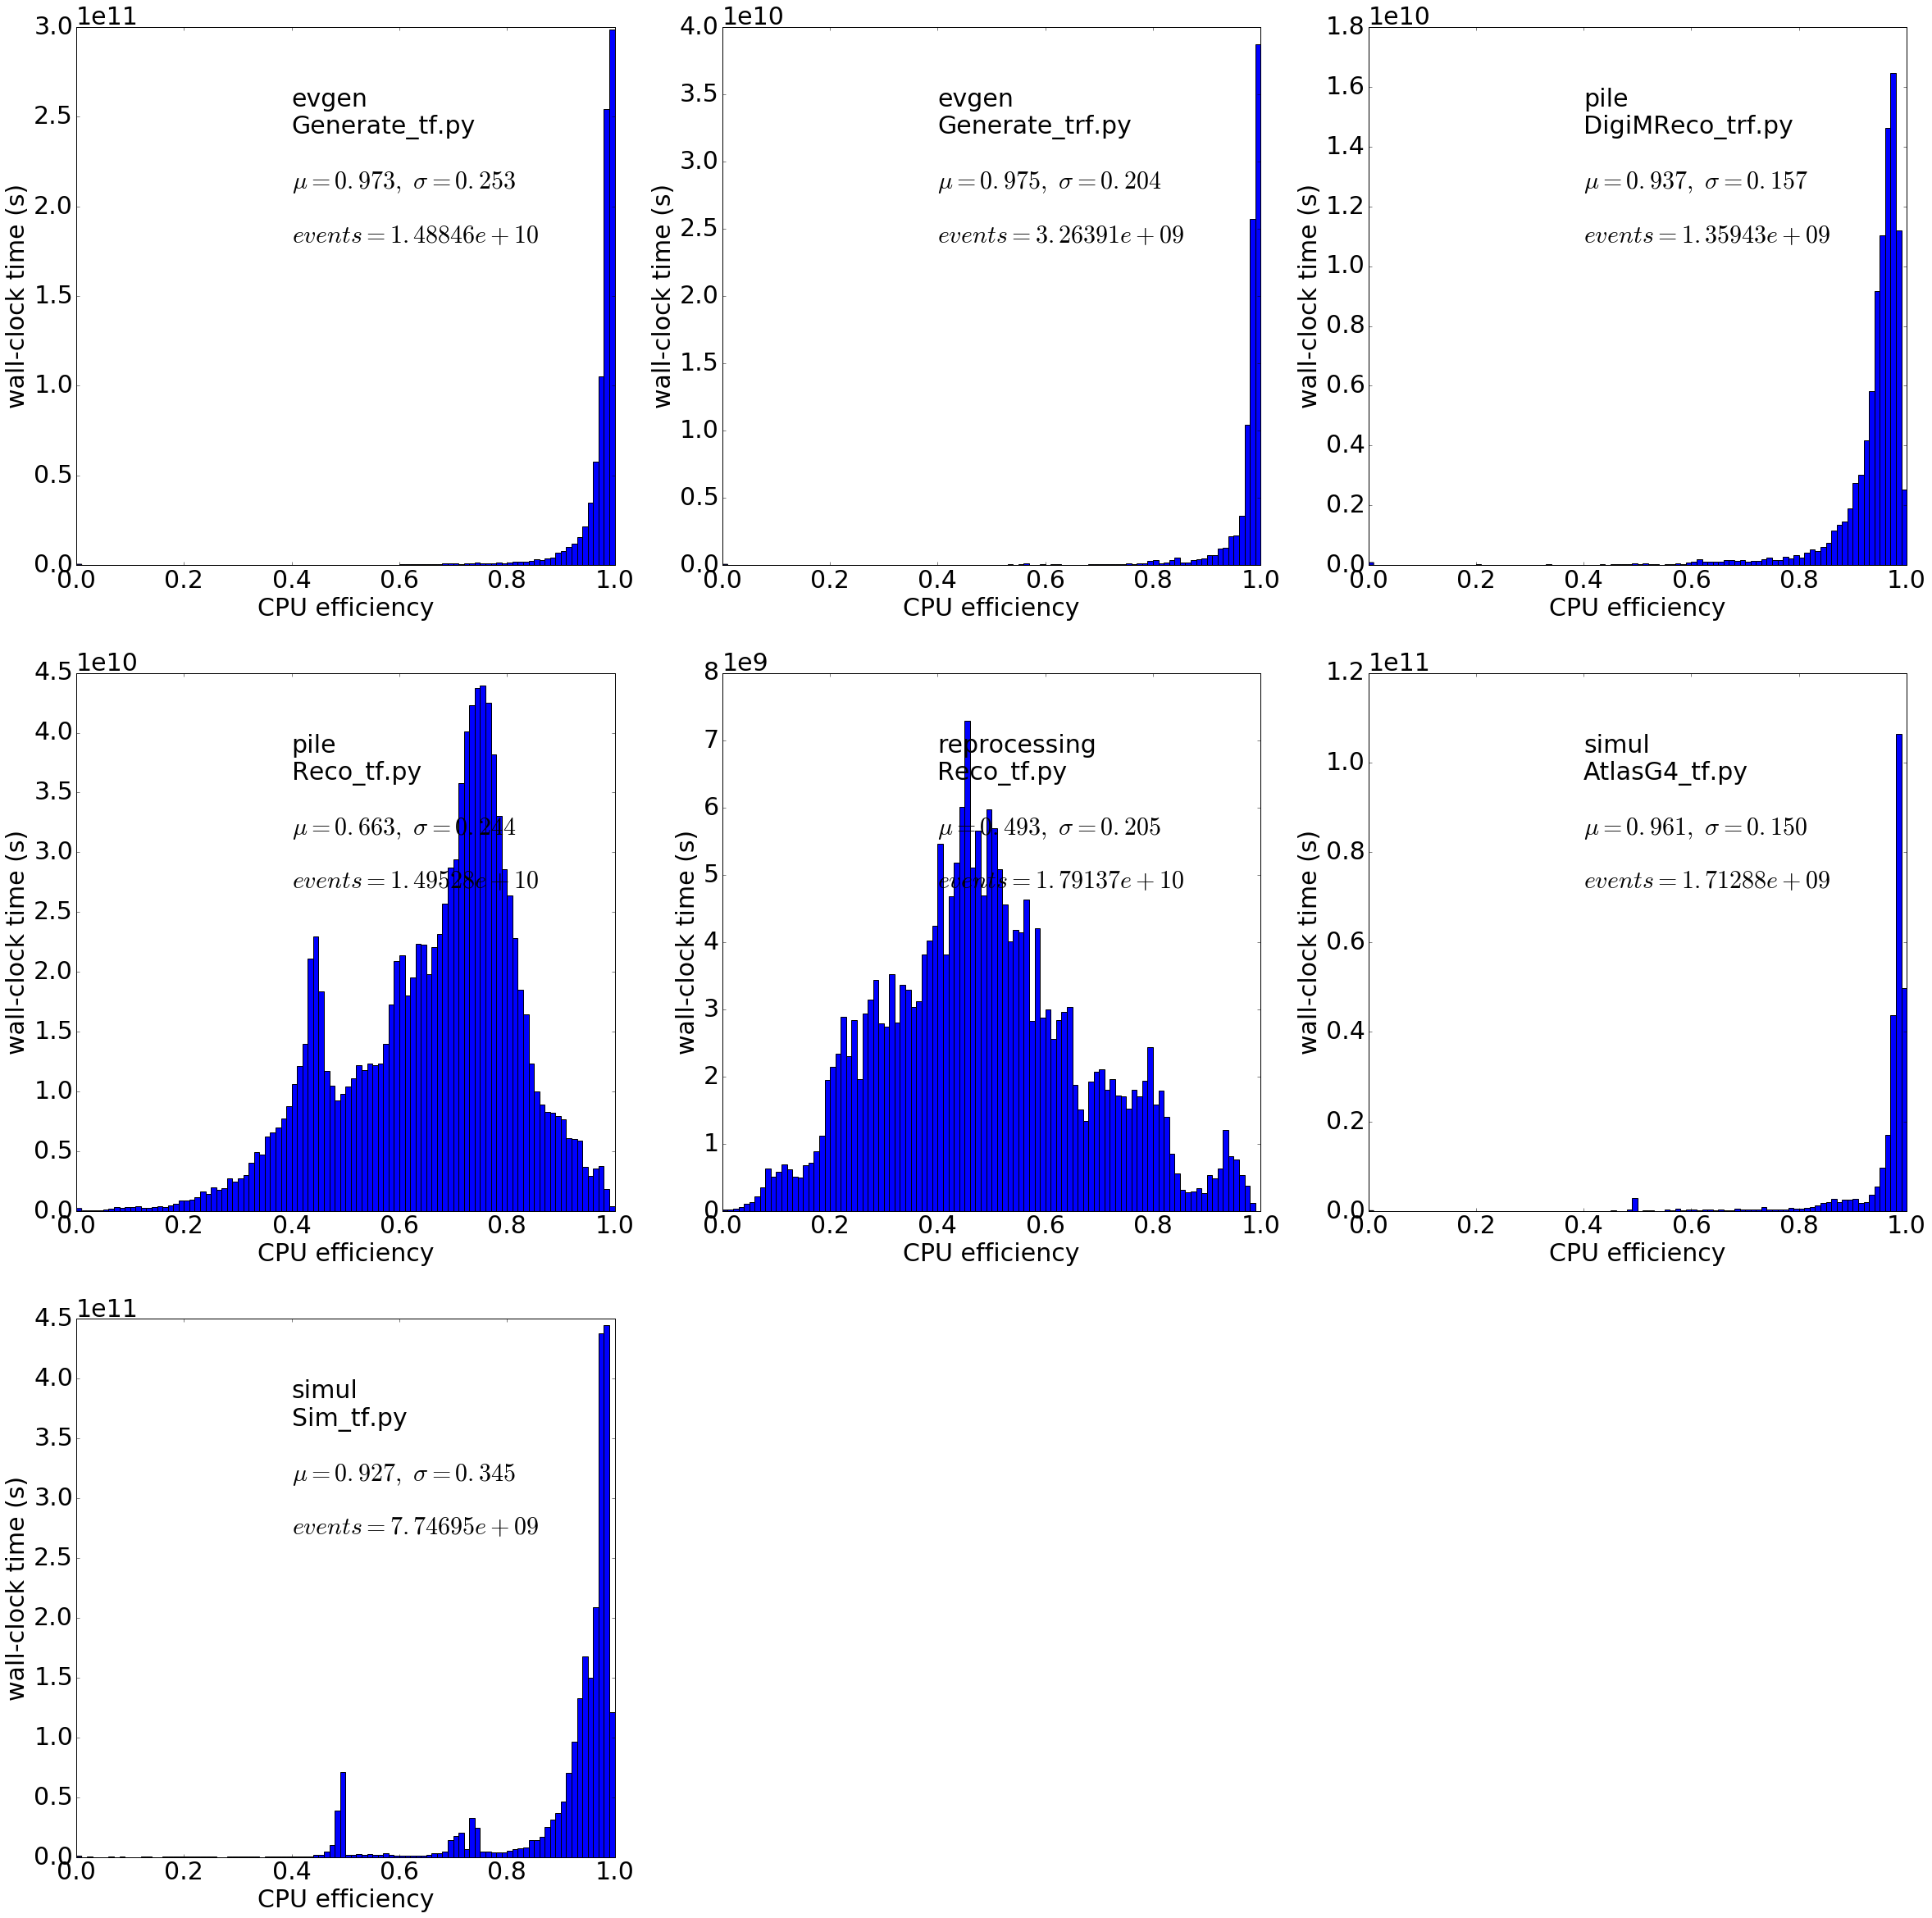

In [47]:
fig = plt.figure(figsize=(40,40))
plt.rcParams.update({'font.size': 30})
var = 'eff'
wc_tot = df['wc'].sum()
print 'Total wall-clock: %g s' % wc_tot
print 'Total wall-clock of evgen: %g s' % df[df.processingtype == 'evgen']['wc'].sum()
print 'Total wall-clock of evgen with low efficiency: %g s' % df[(df.processingtype == 'evgen') & (df['eff'] <= .8)]['wc'].sum()

i = 1

grouped = df.groupby(['processingtype', 'transformation'], as_index=False)

for (p, t), g in grouped:
    if i > 9: break
    if re.search(r"merge", t, flags=re.IGNORECASE):
        continue
    if g['wc'].sum() < 0.015 * wc_tot:
        continue
    mean = np.average(g[var], weights=g['wc'])   # average time weighted with no. of events
    std = math.sqrt(np.average((g[var] - mean)**2, weights=g['wc']))
    range = [0., 1.]
    sp = plt.subplot(3, 3, i)
    plt.hist(g[var].tolist(), bins=100, range=range, weights=g['wc'].tolist(), log=False)   # integral is total no. of events
    plt.xlabel('CPU efficiency')
    plt.ylabel('wall-clock time (s)')
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    plt.text(t_x(.4), t_y(.8), p+'\n'+t)
    stats = r'$\mu=%.3f,\ \sigma=%.3f$' % (mean, std)
    plt.text(t_x(.4), t_y(.7), stats)
    stats = r'$\mathit{events}=%g$' % g['jevts'].sum()
    plt.text(t_x(.4), t_y(.6), stats)
    i += 1

## Find tasks with a given efficiency

In [48]:
ptype = 'evgen'
trans = 'Generate_tf.py'
eff_range = [0.95, 1.]

tasks = list()
grouped = df.groupby(['processingtype', 'transformation', 'jeditaskid'], as_index=False)
for (p, t, j), g in grouped:
    if (p != ptype or t != trans): continue
    if re.search(r"merge", t, flags=re.IGNORECASE):
        continue
    mean = np.average(g['eff'], weights=g['jevts'])   # average time weighted with no. of events
    if eff_range[0] <= mean <= eff_range[1]:
        tasks.append(j)

In [49]:
print tasks[:10]
df[df['jeditaskid'] == 4608021]

[4608021, 4632200, 4675484, 4847335, 4865581, 4865582, 4865584, 4874071, 4884835, 4904948]


,jeditaskid,processingtype,transformation,atlrel,site,cputype,njobs,cpuevt_avg,cpuevt_rms,wallevt_avg,wallevt_rms,cpu,wc,cores,jevts,eff
3780,4608021,evgen,Generate_tf.py,Atlas-19.2.1,BNL_PROD,s+Intel(R) Xeon(R) CPU X5660 @ 2.80...,169,15.903467,2.444203,16.388178,2.527222,5375372,5539204,1,338000,0.970608
3783,4608021,evgen,Generate_tf.py,Atlas-19.2.1,BNL_PROD,s+Intel(R) Xeon(R) CPU X5650 @ 2.67...,148,17.359794,1.503157,17.953821,1.509653,5138499,5314331,1,296000,0.966718
3786,4608021,evgen,Generate_tf.py,Atlas-19.2.1,BNL_PROD,s+Intel(R) Xeon(R) CPU X5560 @ 2.80...,136,10.800294,0.261512,11.060158,0.270021,2937680,3008363,1,272000,0.976512
3790,4608021,evgen,Generate_tf.py,Atlas-19.2.1,BNL_PROD,s+Intel(R) Xeon(R) CPU E5-2660 v2 @ 2.20GHz 25...,11,19.620000,0.556666,20.504455,0.669778,431640,451098,1,22000,0.957023
3791,4608021,evgen,Generate_tf.py,Atlas-19.2.1,BNL_PROD,s+Intel(R) Xeon(R) CPU E5-2660 0 @ 2.20GHz 204...,15,16.613400,0.336580,17.424767,0.336711,498402,522743,1,30000,0.953430
3796,4608021,evgen,Generate_tf.py,Atlas-19.2.1,SWT2_CPB,s+Intel(R) Xeon(R) CPU E5620 @ 2.40...,6,17.319417,0.608994,17.675167,0.618955,207833,212102,1,12000,0.979868
3797,4608021,evgen,Generate_tf.py,Atlas-19.2.1,SWT2_CPB,s+Dual-Core AMD Opteron(tm) Processor 2220 102...,4,15.453625,0.373827,15.912625,0.437918,123629,127301,1,8000,0.971249
3798,4608021,evgen,Generate_tf.py,Atlas-19.2.1,MPPMU,s+Intel(R) Xeon(R) CPU E5-2670 0 @ 2.60GHz 204...,1,8.367000,0.000000,8.568500,0.000000,16734,17137,1,2000,0.976484


## Distribution of time/event for jobs inside a task

In [50]:
ptype = 'evgen'
trans = 'Generate_tf.py'

# Find JEDI task with given parameters
tot_evts = dict()
grouped = df.groupby(['processingtype', 'transformation', 'jeditaskid'], as_index=False)
for (p, t, j), g in grouped:
    if (p != ptype or t != trans): continue
    tot_evts[j] = g['jevts'].sum()

biggest_tasks = sorted(tot_evts, key=tot_evts.get, reverse=True)
a = biggest_tasks[:1]
random_task = np.random.choice(a, 1)
print random_task

[8762011]


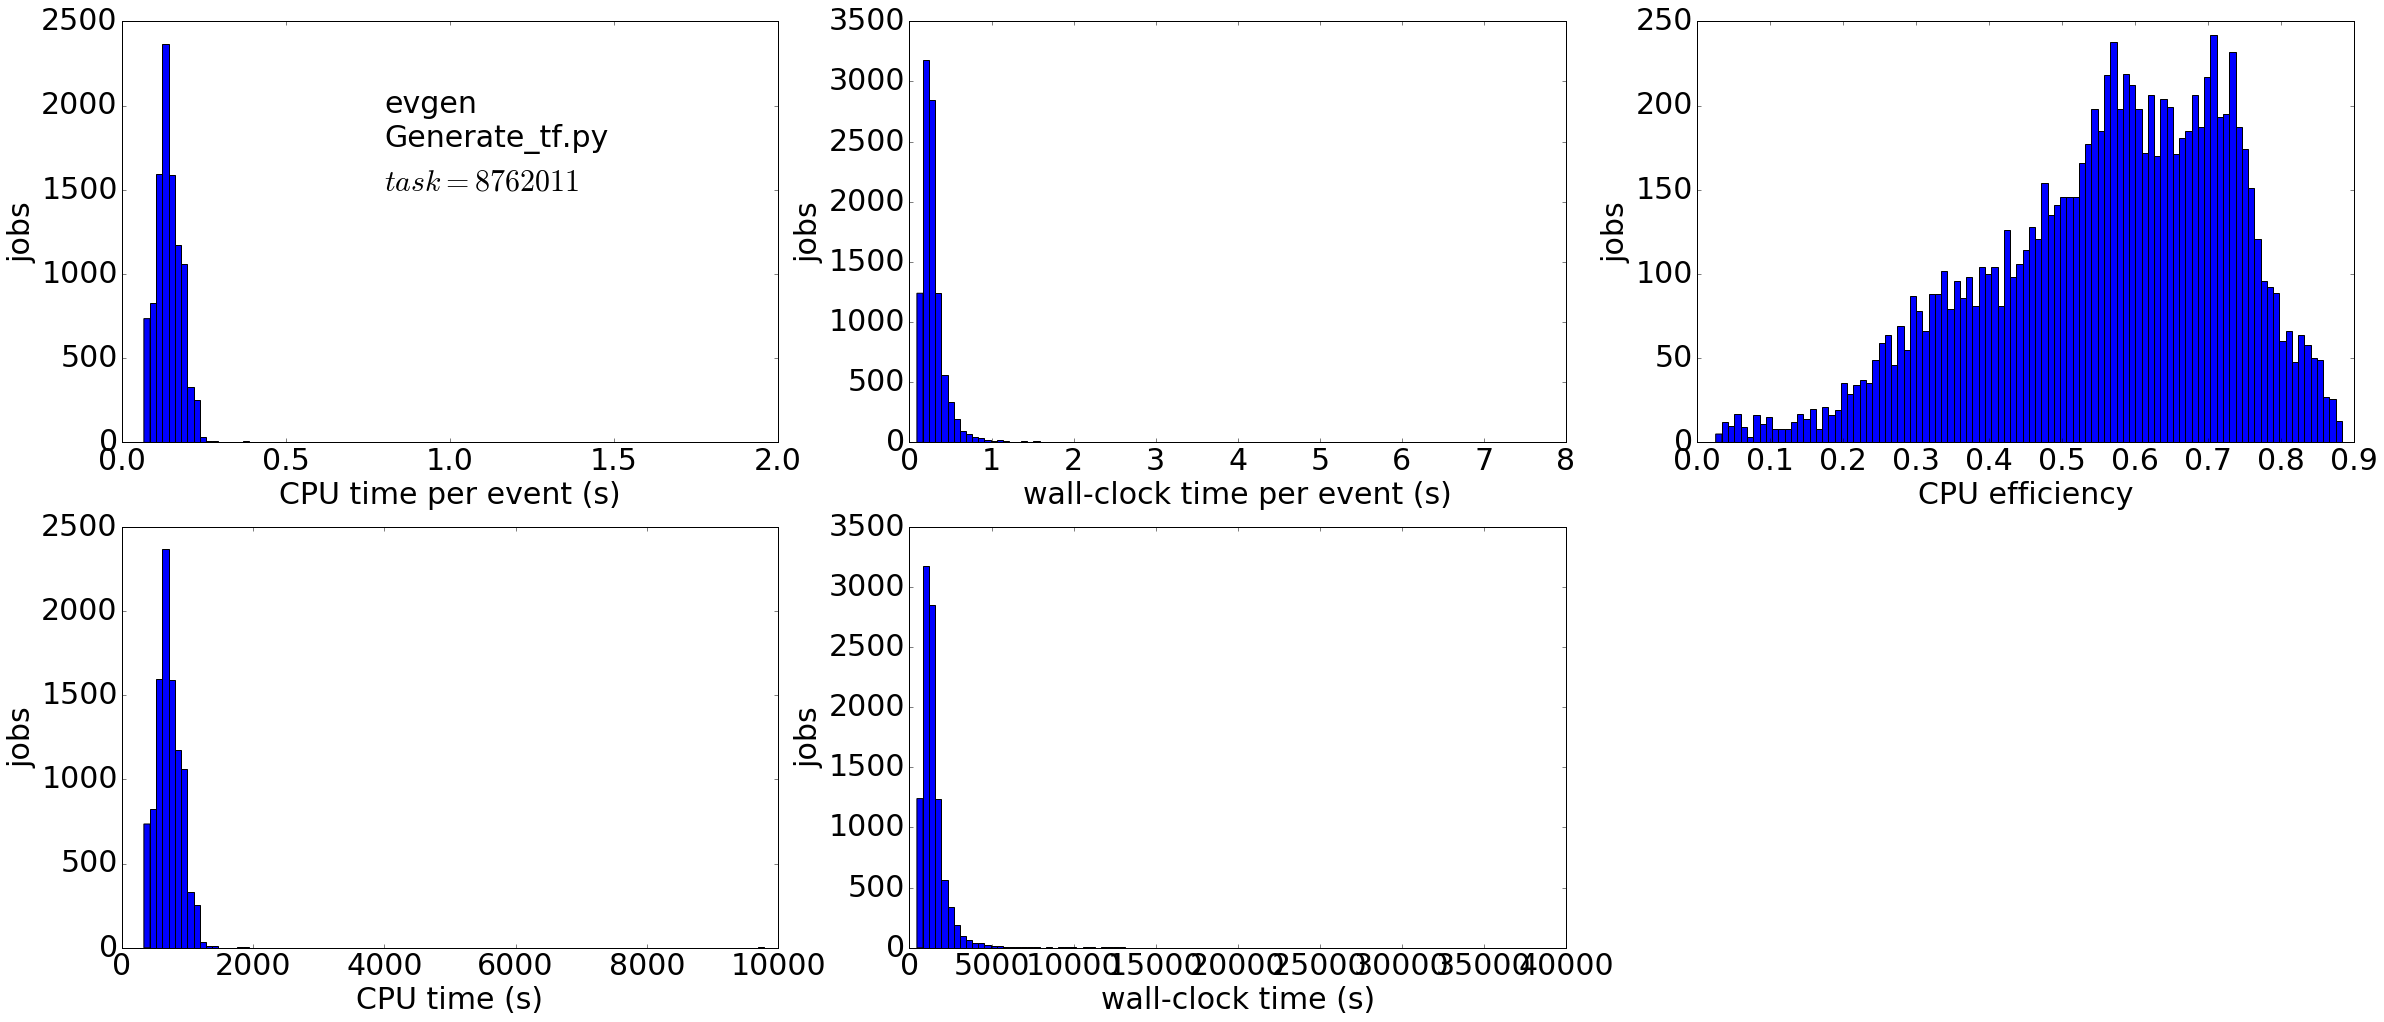

In [53]:
fig2 = plt.figure(figsize=(40,80))
plt.rcParams.update({'font.size': 30})
i = 1
for t in random_task:
    s = {
        "size": 10000,
        "_source": ["cpuconsumptiontime", "wall_time", "corecount", "nevents"],
        "query": {
            "filtered": {
                "filter": {
                    "bool": {
                        "must": [
                            { "match": { "jeditaskid": str(t)}},
                            { "range": {"nevents": {"gte": 1}}},
                            { "range": {"wall_time": {"gte": 60}}},
                            { "match": {"jobstatus": "finished"}}
                        ]
                    }
                }
            }
        }
    }
    res = es.search(index=ind, body=s, request_timeout=300)
    cputimes = list()
    wctimes = list()
    effs = list()
    cpus = list()
    wcs = list()
    for h in res['hits']['hits']:
        vars = h['_source']
        cpuevt = vars['cpuconsumptiontime'] / vars['nevents']
        wcevt = vars['wall_time'] * vars['corecount'] / vars['nevents']
        eff = vars['cpuconsumptiontime'] / vars['wall_time'] / vars['corecount']
        cpu = vars['cpuconsumptiontime']
        wc = vars['wall_time'] * vars['corecount']
        cputimes.append(cpuevt)
        wctimes.append(wcevt)
        effs.append(eff)
        cpus.append(cpu)
        wcs.append(wc)
    sp = plt.subplot(9, 3, i)
    plt.hist(cputimes, bins=100, range=None)
    plt.xlabel('CPU time per event (s)')
    plt.ylabel('jobs')
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    plt.text(t_x(0.4), t_y(.7), ptype+'\n'+trans)
    stats = r'$task=%d$' % (t)
    plt.text(t_x(.4), t_y(.6), stats)
    sp = plt.subplot(9, 3, i+1)
    plt.hist(wctimes, bins=100, range=None)
    plt.xlabel('wall-clock time per event (s)')
    plt.ylabel('jobs')
    sp = plt.subplot(9, 3, i+2)
    plt.hist(effs, bins=100, range=None)
    plt.xlabel('CPU efficiency')
    plt.ylabel('jobs')
    sp = plt.subplot(9, 3, i+3)
    plt.hist(cpus, bins=100, range=None)
    plt.xlabel('CPU time (s)')
    plt.ylabel('jobs')
    sp = plt.subplot(9, 3, i+4)
    plt.hist(wcs, bins=100, range=None)
    plt.xlabel('wall-clock time (s)')
    plt.ylabel('jobs')
    i += 5

## Examine a single task

See the distribution of the CPU time per event across different sites for a single task.

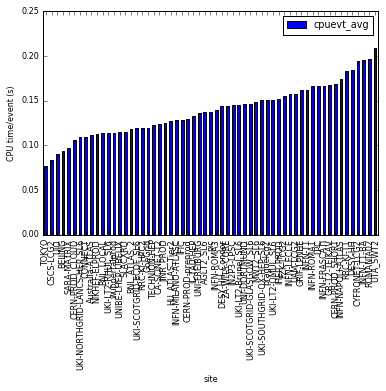

In [55]:
taskid = 8762011
dfx = df[df['jeditaskid'] == taskid]
df2 = dfx.groupby('site').aggregate({'cpuevt_avg': np.mean})
plt.rcParams.update({'font.size': 8})
plt.figure()
df2.sort_values('cpuevt_avg').plot.bar()
plt.ylabel('CPU time/event (s)')

## Distribution of average CPU time per event across different sites for a given task

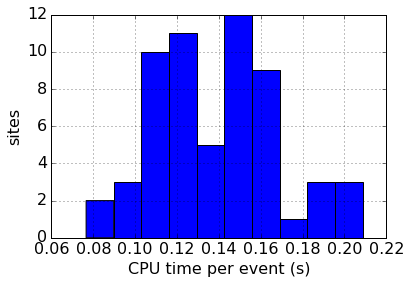

In [56]:
plt.rcParams.update({'font.size': 16})
df2['cpuevt_avg'].hist(bins=10)
plt.xlabel('CPU time per event (s)')
plt.ylabel('sites')

## Analyse all tasks

Study the spread in the CPU time per event on different sites.

In [60]:
ptype = 'evgen'
k = list()
ns = list()
grouped = df.groupby(['jeditaskid', 'site'], as_index=False)
g = grouped['cpuevt_avg'].agg(np.mean)
tasks = g['jeditaskid'].unique()
for t in tasks:
    g2 = g[g.jeditaskid == t]
    n = len(g2)
    ns.append(n)
    if len(g2) < 3: continue
    avg = g2['cpuevt_avg'].mean()   # wrong: mean not weighted
    std = g2['cpuevt_avg'].std()   # wrong: mean not weighted
    if np.isnan(std): continue
    try:
        ratio = std / avg
        k.append(ratio)
    except:
        continue

### Distribution of number of sites used by a task

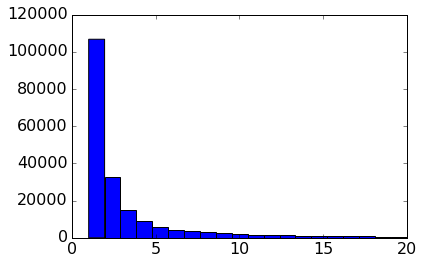

In [61]:
fig = plt.hist(ns, bins=20, range=(1, 20))

### Distribution of the normalised spread of the CPU time per event across different sites

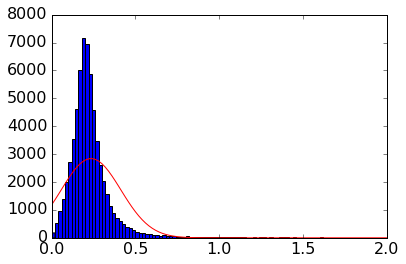

In [62]:
bins = 100
range = (0, 2)
n = len(k)
mu = np.mean(k)
sigma = np.std(k)
fig = plt.hist(k, bins=bins, range=range)
binsize = (range[1] - range[0]) / bins
plt.plot(fig[1], n * binsize/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (fig[1] - mu)**2 / (2 * sigma**2)), color='r')

## Distribution of number of CPU types per site

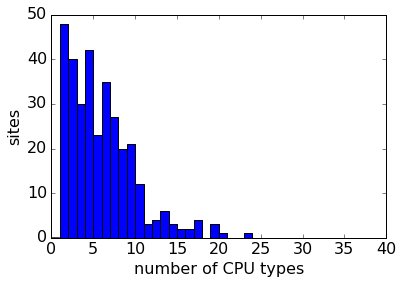

In [63]:
grouped = df.groupby(['site'], as_index=False)
a = grouped.agg({'cputype': 'nunique'})
fig = plt.hist(a['cputype'], bins=40, range=[0., 40.])
plt.xlabel('number of CPU types')
plt.ylabel('sites')

## Ranking of sites by wall-clock

In [64]:
grouped = df.groupby(['site'], as_index=False)
tot_wc = grouped['wc'].sum()
a = tot_wc.sort_values('wc', ascending=False)
bigtotal_wc = a.wc.sum()
a[a.wc > bigtotal_wc * 0.001].site.tolist()

['BNL_PROD_MCORE',
 'MWT2_MCORE',
 'CERN-P1_MCORE',
 'TRIUMF_MCORE',
 'RAL-LCG2_MCORE',
 'AGLT2_MCORE',
 'SLACXRD_MP8',
 'IN2P3-CC_MCORE_HIMEM',
 'CERN-PROD_MCORE',
 'BNL_PROD',
 'SiGNET_MCORE',
 'SWT2_CPB_MCORE',
 'SARA-MATRIX_MCORE',
 'MWT2_SL6',
 'NIKHEF-ELPROD_MCORE',
 'RAL-LCG2_SL6',
 'DESY-HH_MCORE',
 'FZK-LCG2_MCORE',
 'INFN-T1',
 'RRC-KI-T1_MCORE',
 'BU_ATLAS_Tier2_MCORE',
 'UKI-SCOTGRID-GLASGOW_MCORE',
 'INFN-MILANO-ATLASC_MCORE',
 'ORNL_Titan_MCORE',
 'LRZ-LMU_MCORE',
 'CERN-PROD',
 'UKI-NORTHGRID-MAN-HEP_MCORE',
 'pic_MCORE',
 'TOKYO_MCORE',
 'AGLT2_SL6',
 'IN2P3-CC_MCORE',
 'SLACXRD',
 'FZK-LCG2',
 'GRIF-LPNHE_MCORE',
 'Taiwan-LCG2_MCORE',
 'INFN-ROMA1_MCORE',
 'UKI-NORTHGRID-LANCS-HEP_MCORE',
 'wuppertalprod_MCORE',
 'INFN-T1_MCORE',
 'BNL_ATLAS_2',
 'CSCS-LCG2_MCORE',
 'DESY-HH',
 'UKI-SCOTGRID-GLASGOW_SL6',
 'UNI-FREIBURG_MCORE',
 'INFN-NAPOLI-ATLAS_MCORE',
 'UIO_MCORE',
 'INFN-NAPOLI-RECAS_MCORE',
 'INFN-FRASCATI_MCORE',
 'UKI-SOUTHGRID-RALPP_SL6',
 'SWT2_CPB',
 'LRZ-LM

## Find task data

In [65]:
indices = es.cat.indices(index="tasks*", h="index", request_timeout=600).split('\n')
indices = sorted(indices)
indices = [unicode.strip(x) for x in indices if x != '']
ind = ','.join(indices)
print ind

tasks_archive_2014,tasks_archive_2015,tasks_archive_2016,tasks_archive_2016-04,tasks_archive_2016-05,tasks_archive_2016-06


In [66]:
fields = ["campaign", "corecount", "creationdate", "jeditaskid", "processingtype", "prodsourcelabel", "site", "status", "taskname"]
s = {
    "_source": fields,
    "query": {
        "filtered": {
            "filter": {
                "match": { "tasktype": "prod"}
            }
        }
    }
}
#res = es.search(index=ind, body=s, request_timeout=300)
output_file = 'tasksdata.csv'
with open(output_file, 'w') as f:
    writer = csv.DictWriter(f, fieldnames=fields, lineterminator='\n')
    res = helpers.scan(es, query=s)
    for r in res:
        attrs = r['_source']
        writer.writerow(attrs)

In [67]:
df_t = pd.read_csv(output_file, names=fields)
jmap = df_t[['jeditaskid', 'taskname', 'campaign']]
df2 = pd.merge(df, jmap, on='jeditaskid')

In [68]:
df2

,jeditaskid,processingtype,transformation,atlrel,site,cputype,njobs,cpuevt_avg,cpuevt_rms,wallevt_avg,wallevt_rms,cpu,wc,cores,jevts,eff,taskname,campaign
0,4610250,simul,Sim_tf.py,Atlas-17.7.4,CERN-P1_MCORE_HI,s+Westmere E56xx/L56xx/X56xx (Nehalem-C) 4096 KB,6589,261.843331,12.955051,302.893113,14.977942,172528571,199576272,8,658900,0.864689,mc14_13TeV.147408.PowhegPythia8_AZNLO_Ztautau....,MC14a
1,4610250,simul,Sim_tf.py,Atlas-17.7.4,CERN-P1_MCORE_HI,s+Intel Core i7 9xx (Nehalem Class Core i7) 40...,2696,275.686736,13.540158,319.230059,15.540752,74325144,86064424,8,269600,0.863807,mc14_13TeV.147408.PowhegPythia8_AZNLO_Ztautau....,MC14a
2,4610250,simul,Sim_tf.py,Atlas-17.7.4,IN2P3-CC_MCORE,s+Intel(R) Xeon(R) CPU X5650 @ 2.67...,8470,303.486125,47.606507,339.770087,51.237895,257052748,287785264,8,847000,0.892372,mc14_13TeV.147408.PowhegPythia8_AZNLO_Ztautau....,MC14a
3,4610250,simul,Sim_tf.py,Atlas-17.7.4,SiGNET_MCORE,s+AMD Opteron(TM) Processor 6274 2048 KB,2372,417.893229,21.192265,492.759224,34.353389,99124274,116882488,8,237200,0.850179,mc14_13TeV.147408.PowhegPythia8_AZNLO_Ztautau....,MC14a
4,4610250,simul,Sim_tf.py,Atlas-17.7.4,SiGNET_MCORE,s+AMD Opteron(tm) Processor 6378 2048 KB,1971,322.133465,16.980674,388.736154,33.728566,63492506,76619896,8,197100,0.832033,mc14_13TeV.147408.PowhegPythia8_AZNLO_Ztautau....,MC14a
5,4610250,simul,Sim_tf.py,Atlas-17.7.4,SiGNET_MCORE,s+Six-Core AMD Opteron(tm) Processor 2431 512 KB,1475,259.439241,12.895854,319.460122,32.525869,38267288,47120368,8,147500,0.817232,mc14_13TeV.147408.PowhegPythia8_AZNLO_Ztautau....,MC14a
6,4610250,simul,Sim_tf.py,Atlas-17.7.4,SiGNET_MCORE,s+Quad-Core AMD Opteron(tm) Processor 2350 512 KB,734,324.948488,16.344728,393.120000,29.522031,23851219,28855008,8,73400,0.829077,mc14_13TeV.147408.PowhegPythia8_AZNLO_Ztautau....,MC14a
7,4610250,simul,Sim_tf.py,Atlas-17.7.4,SiGNET_MCORE,s+Quad-Core AMD Opteron(tm) Processor 2376 512 KB,168,271.303869,13.696600,323.569048,21.872265,4557905,5435960,8,16800,0.840137,mc14_13TeV.147408.PowhegPythia8_AZNLO_Ztautau....,MC14a
8,4610250,simul,Sim_tf.py,Atlas-17.7.4,MWT2_MCORE,s+Intel(R) Xeon(R) CPU X5660 @ 2.80...,2045,340.169599,44.544212,380.931130,50.115591,69564683,77900416,8,204500,0.893565,mc14_13TeV.147408.PowhegPythia8_AZNLO_Ztautau....,MC14a
9,4610250,simul,Sim_tf.py,Atlas-17.7.4,MWT2_MCORE,s+Intel(R) Xeon(R) CPU E5-2670 0 @ 2.60GHz 204...,1057,329.360785,54.969879,374.456008,60.533405,34813435,39580000,8,105700,0.878741,mc14_13TeV.147408.PowhegPythia8_AZNLO_Ztautau....,MC14a


## Split data file into N random samples

In [18]:
input = 'task_cpu.csv'
no_outputs = 2
g = list()
output_pattern = 'task_cpu_sub_%s.csv'
p = re.compile('\d+')
jtask_old = ''
for i in range(no_outputs):
    gname = output_pattern % (str(i))
    g.append(open(gname, 'w'))
    
with open(input) as f:
    data = f.readlines()
    data.sort()
    for line in data:
        jtask = p.match(line).group(0)
        if jtask != jtask_old:
            jtask_old = jtask
            i = random.randint(0, no_outputs-1)
        g[i].write(line)

for i in range(no_outputs):
    g[i].close()